In [1]:
import os, glob
import thinkdsp
import thinkplot
import pickle
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import signalprocessing as sigp
import soundmfccparams as smfccp
import plotutilities as pltut

from graphviz import Source
from scipy.io.wavfile import write
from IPython.display import SVG
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from mlxtend.plotting import plot_decision_regions

os.environ["PATH"] += os.pathsep + 'F:/Applications/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin/graphviz'

In [2]:
# Путь к сигналам
signalPath = r"C:/Users/Vaclav/Documents/Diploma/Clean Signals/ETHALON_SIGNAL"
noisePath = r"C:/Users/Vaclav/Documents/Diploma/Clean Signals/ETHALON_NOISE"

In [3]:
## Вычисление спектральных характеристик
signalMaxAmp = sigp.calculate_mean_amplitude_list(signalPath)
signalMaxAmpSplit = sigp.split_calculate_mean_amplitude_list(signalPath)
signalSco = sigp.calculate_SCO_amplitude_list(signalPath)
signalCentroid = sigp.calculate_CENTROID_list(signalPath)
signalSpread = sigp.calculate_SPREAD_list(signalPath)
signalFlatness = sigp.calculate_FLATNESS_list(signalPath)
# Вычисление MFCC params (in Dataframe)
#signalMfcc = smfccp.compute_mfcc(signalPath)

## Вычисление спектральных характеристик
noiseMaxAmp = sigp.calculate_mean_amplitude_list(noisePath)
noiseMaxAmpSplit = sigp.split_calculate_mean_amplitude_list(noisePath)
noiseSco = sigp.calculate_SCO_amplitude_list(noisePath)
noiseCentroid = sigp.calculate_CENTROID_list(noisePath)
noiseSpread = sigp.calculate_SPREAD_list(noisePath)
noiseFlatness = sigp.calculate_FLATNESS_list(noisePath)
# Вычисление MFCC params (in Dataframe)
#noiseMfcc = smfccp.compute_mfcc(noisePath)

C:\Users\Vaclav\Documents\Diploma\Notebooks\Classifier\signalprocessing.py:318: RuntimeWarning: divide by zero encountered in log
  return (np.exp((1 / length) * np.sum(np.log(magnitudes)))) / ((1 / length) * np.sum(magnitudes))


In [4]:
# Разбивка сигналов на 4 части
sigLst1 = [item[0] for item in signalMaxAmpSplit]
sigLst2 = [item[1] for item in signalMaxAmpSplit]
sigLst3 = [item[2] for item in signalMaxAmpSplit]
sigLst4 = [item[3] for item in signalMaxAmpSplit]

# Разбивка шумов на 4 части
noiseLst1 = [item[0] for item in noiseMaxAmpSplit]
noiseLst2 = [item[1] for item in noiseMaxAmpSplit]
noiseLst3 = [item[2] for item in noiseMaxAmpSplit]
noiseLst4 = [item[3] for item in noiseMaxAmpSplit]

In [5]:
signalDataFrame = {'Total MaxAmp': signalMaxAmp, 'Split MaxAmp 1': sigLst1, 'Split MaxAmp 2': sigLst2, 'Split MaxAmp 3': sigLst3, 'Split MaxAmp 4': sigLst4, 'SCO': signalSco, 'Centroid': signalCentroid, 'Spread': signalSpread, 'Flatness': signalFlatness}
signalDataFrame = pd.DataFrame(data=signalDataFrame)
signalDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness
0,59509.798493,14278.283163,35080.329772,43710.522305,11901.186403,4098.793784,2272.203915,2.334269e+06,0.004218
1,119671.990145,41038.114961,59803.143937,74801.275165,42325.735594,3297.059400,2236.542959,3.324602e+06,0.003470
2,51954.281625,5750.844624,23449.350549,40105.749327,25080.507980,4649.874169,2640.622496,1.787836e+06,0.003840
3,51982.973781,3769.711655,34492.988088,39123.276081,4673.387801,4493.320723,2669.846796,2.053052e+06,0.004414
4,75138.663124,11909.941918,23061.202287,59289.146072,35269.746057,3917.824967,2550.049766,2.252243e+06,0.003750


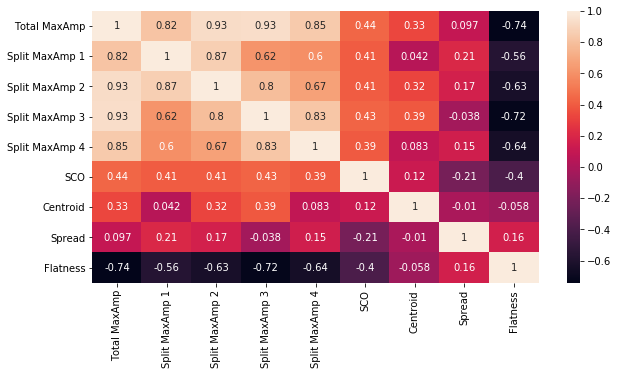

In [6]:
signalCorrMatrix = signalDataFrame.corr()
sn.heatmap(signalCorrMatrix, annot=True)

In [7]:
noiseDataFrame = {'Total MaxAmp': noiseMaxAmp, 'Split MaxAmp 1': noiseLst1, 'Split MaxAmp 2': noiseLst2, 'Split MaxAmp 3': noiseLst3, 'Split MaxAmp 4': noiseLst4, 'SCO': noiseSco, 'Centroid': noiseCentroid, 'Spread': noiseSpread, 'Flatness': noiseFlatness}
noiseDataFrame = pd.DataFrame(data=noiseDataFrame)
noiseDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness
0,58425.447730,20032.109958,44145.746087,26256.060444,13650.189224,676.811454,2774.093258,4.668802e+06,0.006100
1,193406.552449,81855.827637,111871.698183,97127.666066,84202.109730,2578.939096,4662.397442,6.130815e+06,0.002981
2,161153.535845,70389.499921,70749.010067,81626.818814,95371.611515,2615.469034,2378.702283,4.665910e+06,0.003503
3,117942.160213,57514.232862,57524.610011,59439.321884,59754.316941,1652.112933,2521.160815,4.221038e+06,0.004052
4,215839.190424,95859.937534,102068.160895,118552.813090,102172.492410,2806.253051,2469.769855,3.750367e+06,0.002931


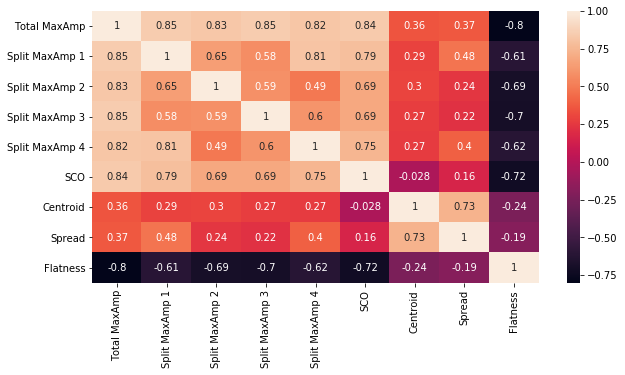

In [8]:
noiseCorrMatrix = noiseDataFrame.corr()
sn.heatmap(noiseCorrMatrix, annot=True)

In [9]:
# Присоединение MFCC
#signalDataFrame = pd.concat([signalDataFrame,signalMfcc], axis=1)
#noiseDataFrame = pd.concat([noiseDataFrame,noiseMfcc], axis=1)

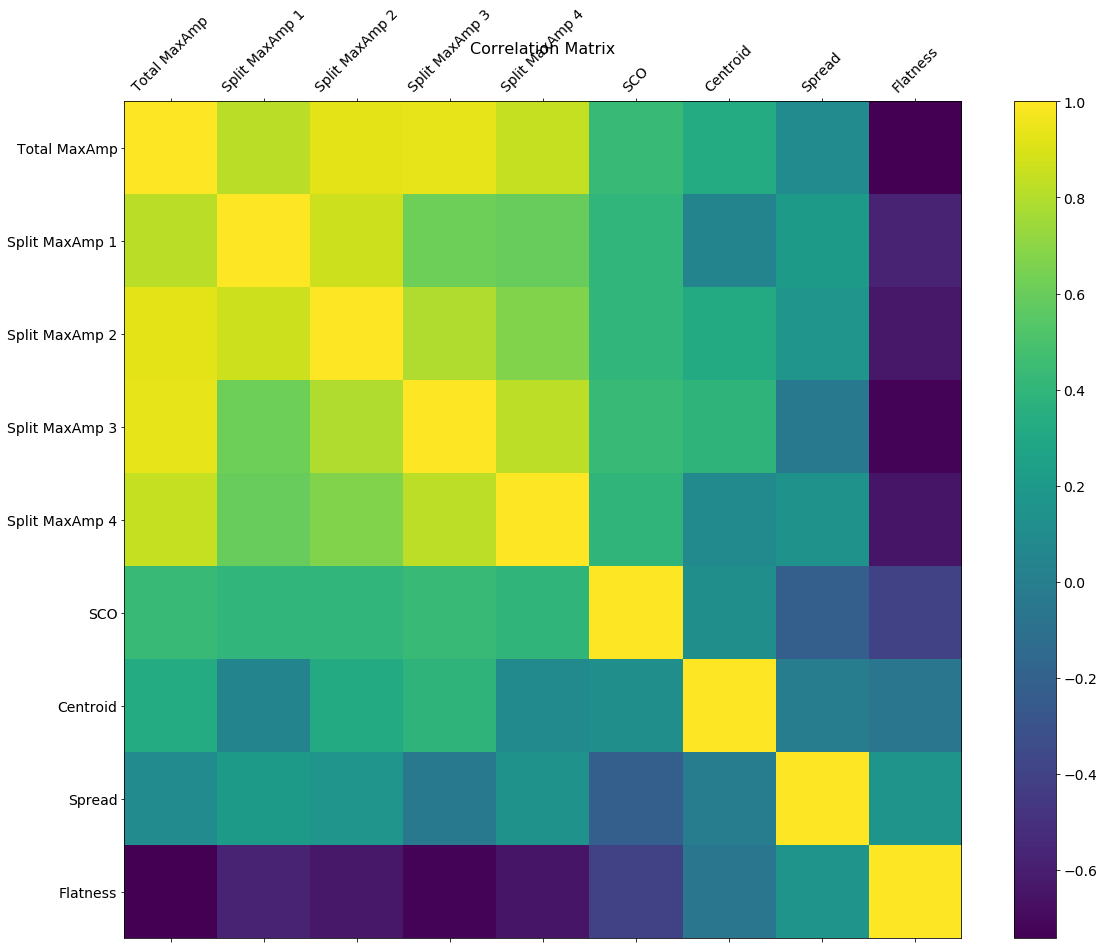

In [10]:
sigp.corr_matrix(signalDataFrame)

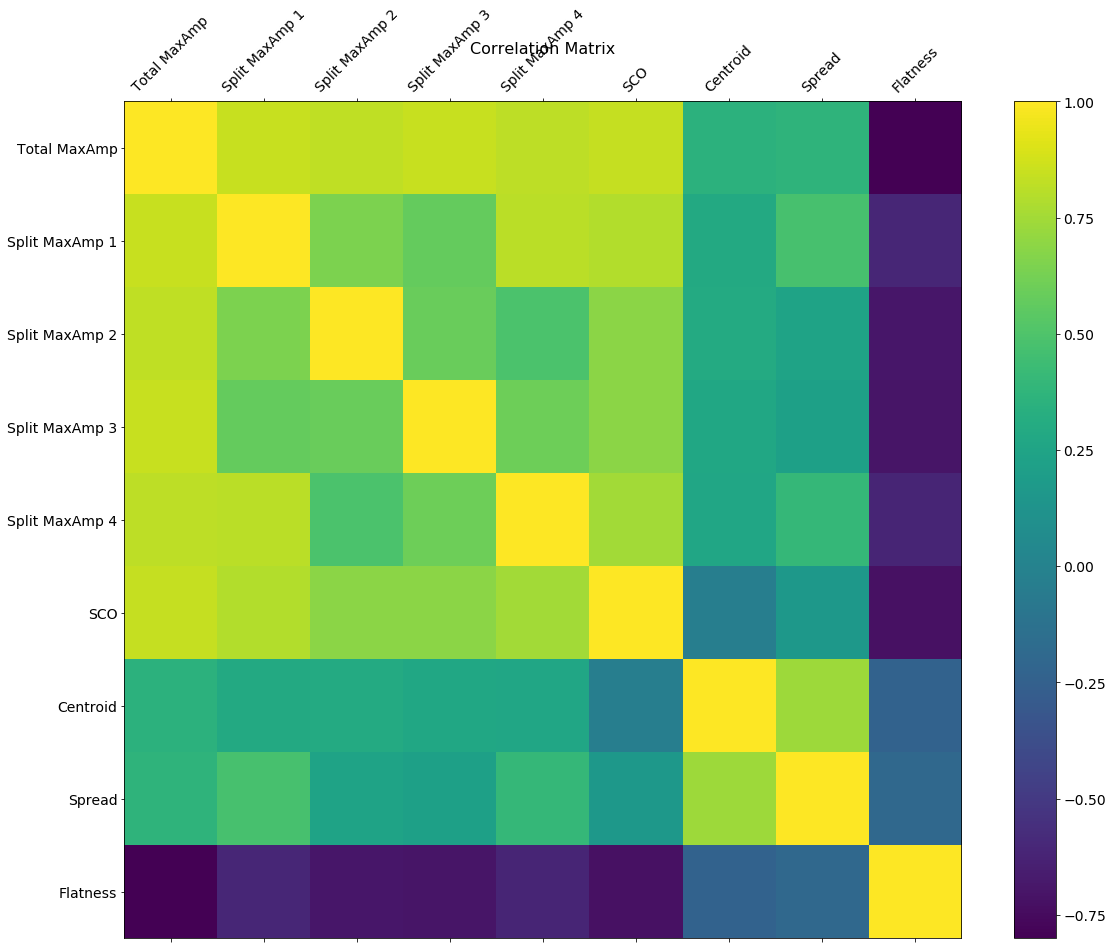

In [11]:
sigp.corr_matrix(noiseDataFrame)

In [12]:
# Using PCA to reduce components
#signalDataFrame = smfccp.pca_dataframe(signalDataFrame, 15)
#noiseDataFrame = smfccp.pca_dataframe(noiseDataFrame, 15)

In [13]:
#rng = range(0, int((len(list(signalDataFrame))-1)/2)+1)

#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
#signalDataFrame.columns = new_cols[:len(list(signalDataFrame))]
signalDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness
0,59509.798493,14278.283163,35080.329772,43710.522305,11901.186403,4098.793784,2272.203915,2.334269e+06,0.004218
1,119671.990145,41038.114961,59803.143937,74801.275165,42325.735594,3297.059400,2236.542959,3.324602e+06,0.003470
2,51954.281625,5750.844624,23449.350549,40105.749327,25080.507980,4649.874169,2640.622496,1.787836e+06,0.003840
3,51982.973781,3769.711655,34492.988088,39123.276081,4673.387801,4493.320723,2669.846796,2.053052e+06,0.004414
4,75138.663124,11909.941918,23061.202287,59289.146072,35269.746057,3917.824967,2550.049766,2.252243e+06,0.003750
...,...,...,...,...,...,...,...,...,...
309,67968.168255,46383.533796,40072.669804,27129.824379,22835.215340,5846.857743,2310.038204,2.624812e+06,0.004398
310,233324.993290,125884.058504,112719.925738,113842.633991,112180.461140,4253.151451,2039.036882,3.330430e+06,0.002635
311,104174.700414,58318.407749,49852.925008,47803.459956,46540.276843,3527.926804,2102.463753,3.176867e+06,0.003890
312,126326.134167,63143.233843,72559.037277,56658.932997,53488.969821,4061.070469,2045.548641,2.804213e+06,0.003336


In [14]:
#rng = range(0, int((len(list(noiseDataFrame))-1)/2)+1)

#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
#noiseDataFrame.columns = new_cols[:len(list(noiseDataFrame))]
noiseDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness
0,58425.447730,20032.109958,44145.746087,26256.060444,13650.189224,676.811454,2774.093258,4.668802e+06,0.006100
1,193406.552449,81855.827637,111871.698183,97127.666066,84202.109730,2578.939096,4662.397442,6.130815e+06,0.002981
2,161153.535845,70389.499921,70749.010067,81626.818814,95371.611515,2615.469034,2378.702283,4.665910e+06,0.003503
3,117942.160213,57514.232862,57524.610011,59439.321884,59754.316941,1652.112933,2521.160815,4.221038e+06,0.004052
4,215839.190424,95859.937534,102068.160895,118552.813090,102172.492410,2806.253051,2469.769855,3.750367e+06,0.002931
...,...,...,...,...,...,...,...,...,...
309,117185.814528,60425.865383,57610.524128,63083.017532,50059.124079,2007.661233,1921.250756,3.257252e+06,0.003640
310,86461.654327,40817.815453,47229.891898,44410.678060,39466.189294,1874.481802,1677.915022,3.106882e+06,0.003947
311,143090.672996,43032.830261,54799.167488,82438.976636,79464.099976,1759.609999,3272.612254,6.445910e+06,0.004001
312,37277.961599,13267.498586,17525.775222,19809.353115,21640.523437,746.894638,2014.257356,4.546420e+06,0.006620


In [15]:
# 1-цы Dataframe (signals)
ones = {'Flag': np.ones(len(signalMaxAmp))}
onesFlag = pd.DataFrame(data=ones)

# 0-ли в Dataframe (noises)
zeroes = {'Flag': np.zeros(len(noiseMaxAmp))}
zeroesFlag = pd.DataFrame(data=zeroes)

# Добавление поля "Flag" в датафрейм
signalDataFrame = signalDataFrame.assign(Flag=onesFlag['Flag'])
noiseDataFrame = noiseDataFrame.assign(Flag=zeroesFlag['Flag'])

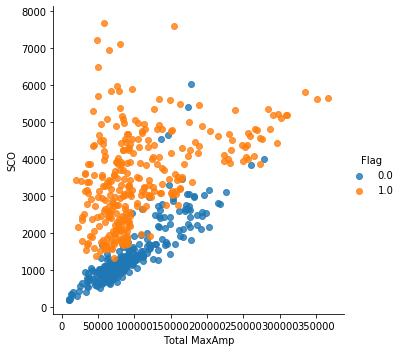

In [16]:
# Объединение сигналов и шумов в обучающий dataframe
learningDataframe = pd.merge(signalDataFrame, noiseDataFrame, how='outer')

# Visualizing the data (1 - signal, 0 - noise)
sn.lmplot('Total MaxAmp', 'SCO', data=learningDataframe, hue="Flag", fit_reg=False)
#sn.lmplot('type_0', 'type_2', data=learningDataframe, hue="Flag", fit_reg=False)

In [17]:
learningDataframe.to_csv("learningDataframe.csv", sep='\t', encoding='utf-8', index=False)

In [18]:
learningDataframe = pd.read_csv('learningDataframe.csv', sep='\t') 
learningDataframe

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,Flag
0,59509.798493,14278.283163,35080.329772,43710.522305,11901.186403,4098.793784,2272.203915,2.334269e+06,0.004218,1.0
1,119671.990145,41038.114961,59803.143937,74801.275165,42325.735594,3297.059400,2236.542959,3.324602e+06,0.003470,1.0
2,51954.281625,5750.844624,23449.350549,40105.749327,25080.507980,4649.874169,2640.622496,1.787836e+06,0.003840,1.0
3,51982.973781,3769.711655,34492.988088,39123.276081,4673.387801,4493.320723,2669.846796,2.053052e+06,0.004414,1.0
4,75138.663124,11909.941918,23061.202287,59289.146072,35269.746057,3917.824967,2550.049766,2.252243e+06,0.003750,1.0
...,...,...,...,...,...,...,...,...,...,...
623,117185.814528,60425.865383,57610.524128,63083.017532,50059.124079,2007.661233,1921.250756,3.257252e+06,0.003640,0.0
624,86461.654327,40817.815453,47229.891898,44410.678060,39466.189294,1874.481802,1677.915022,3.106882e+06,0.003947,0.0
625,143090.672996,43032.830261,54799.167488,82438.976636,79464.099976,1759.609999,3272.612254,6.445910e+06,0.004001,0.0
626,37277.961599,13267.498586,17525.775222,19809.353115,21640.523437,746.894638,2014.257356,4.546420e+06,0.006620,0.0


In [19]:
############################################################################## TRAIN ##############################################################################

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.8s finished


Average number of nodes 25
Average maximum depth 6
Best estimator is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=16, max_features=None,
                       max_leaf_nodes=24, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=157,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Recall Baseline: 1.0 Test: 0.97 Train: 0.99
Precision Baseline: 0.48 Test: 0.97 Train: 0.98
Roc Baseline: 0.5 Test: 0.99 Train: 1.0
Confusion matrix, without normalization
[[95  3]
 [ 3 88]]


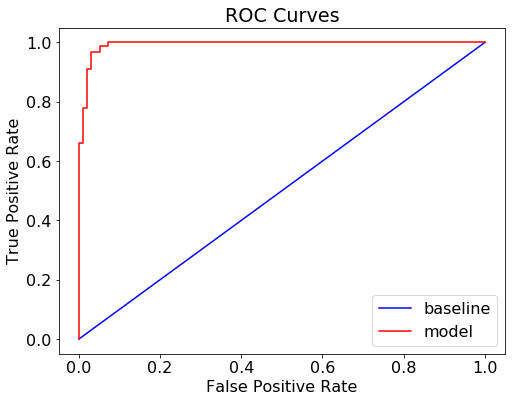

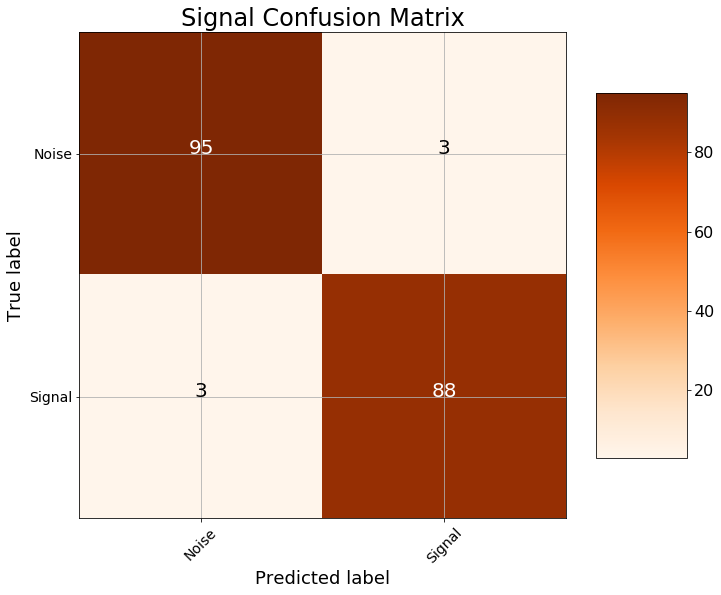

In [20]:
# 30% экземпляров на обучение
train, test, train_labels, test_labels = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=0)

# Сетка параметров модели RF
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.linspace(3, 30).astype(int)),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None] + list(np.linspace(1, 50, 100).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True]
}


# RF модель
estimator = RandomForestClassifier(random_state = 0)

# Модель random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 5, 
                        n_iter = 25, verbose = 5, random_state=0)

# Fit 
rs.fit(train, train_labels)

# Поиск лучшего
best_model = rs.best_estimator_
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]
rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

# Вывод результатов и оценка качества
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')
print(f'Best estimator is {rs.best_estimator_}')

sigp.evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, test_labels, train_labels)
cm = sigp.confusion_matrix(test_labels, rf_predictions)
sigp.plot_confusion_matrix(cm, classes = ['Noise', 'Signal'], title = 'Signal Confusion Matrix')

In [21]:
# Отчет о классификации RF
print('Random Forest Classifier\n',
      classification_report(test_labels, best_model.predict(test), target_names=['Noise', 'Signal']))

Random Forest Classifier
               precision    recall  f1-score   support

       Noise       0.97      0.97      0.97        98
      Signal       0.97      0.97      0.97        91

    accuracy                           0.97       189
   macro avg       0.97      0.97      0.97       189
weighted avg       0.97      0.97      0.97       189



In [22]:
# Обучение классификатора на полной обучеющей выборке
best_model.fit(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=16, max_features=None,
                       max_leaf_nodes=24, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=157,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

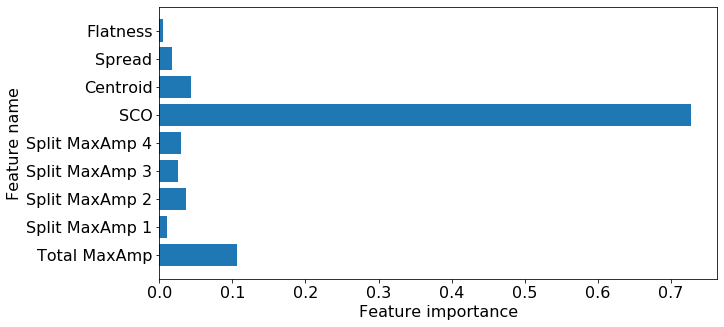

In [23]:
# Getting featurs' importance
pltut.plot_feature_importances(best_model, learningDataframe.drop(columns=['Flag']).columns)

In [24]:
# Plotting decision regions
#fig, ax = plt.subplots()
# Decision region for feature 3 = 1.5
#value = 1.5
# Plot training sample with feature 3 = 1.5 +/- 0.75
#width = 0.75

# Plotting decision regions
#fig = plot_decision_regions(train.values, train_labels.values.astype(np.integer), clf=best_model,
#              feature_index=[0,5],
#              filler_feature_values={1: value, 2: value, 3: value, 4: value, 6: value, 7: value, 8: value,
#                                    9: value, 10: value, 11: value, 12: value, 13: value, 14: value, 15: value,
#                                    16: value, 17: value, 18: value, 19: value, 20: value, 21: value, 22: value,
#                                    23: value, 24: value, 25: value, 26: value, 27: value, 28: value},  
#              filler_feature_ranges={1: width, 2: width, 3: width, 4: width, 6: width, 7: width, 8: width,
#                                    9: width, 10: width, 11: width, 12: width, 13: width, 14: width, 15: width,
#                                    16: width, 17: width, 18: width, 19: width, 20: width, 21: width, 22: width,
#                                    23: width, 24: width, 25: width, 26: width, 27: width, 28: width},
#                           legend=2, ax=ax)

# Adding axes annotations
#plt.xlabel('Total MaxAmp')
#plt.ylabel('SCO')
#plt.title('Random Forest Signal Classifier')
#plt.show()

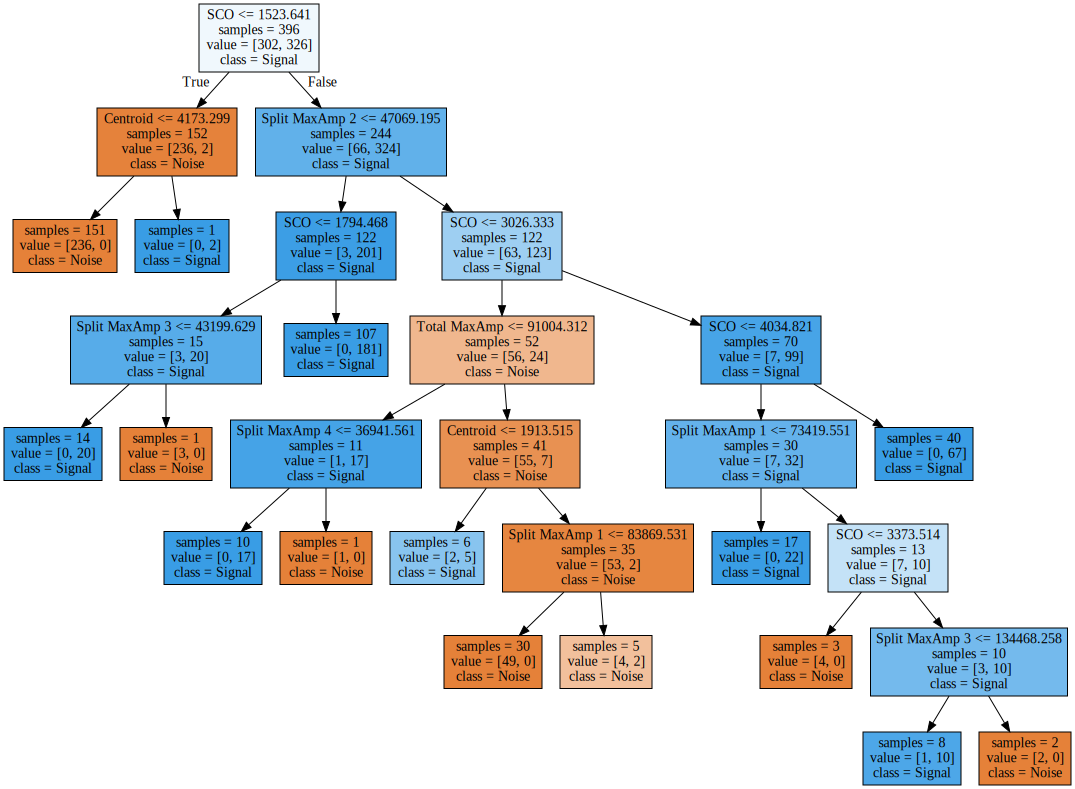

In [25]:
# Selected tree visualization
pltut.plot_decision_tree(best_model.estimators_[0], learningDataframe.drop(columns=['Flag']).columns, ['Noise', 'Signal'])

In [26]:
# Graphviz trees visualization (.estimators_[0] - first tree)
feature_names=learningDataframe.drop(columns=['Flag']).columns
class_names=['Noise', 'Signal']

#graph = Source(export_graphviz(best_model.estimators_[0],
#                feature_names=feature_names,
#                class_names=class_names,
#                filled=True,
#                rounded=False))
#display(SVG(graph.pipe(format='svg')))
#graph.render(filename='tree.dot', format='png')

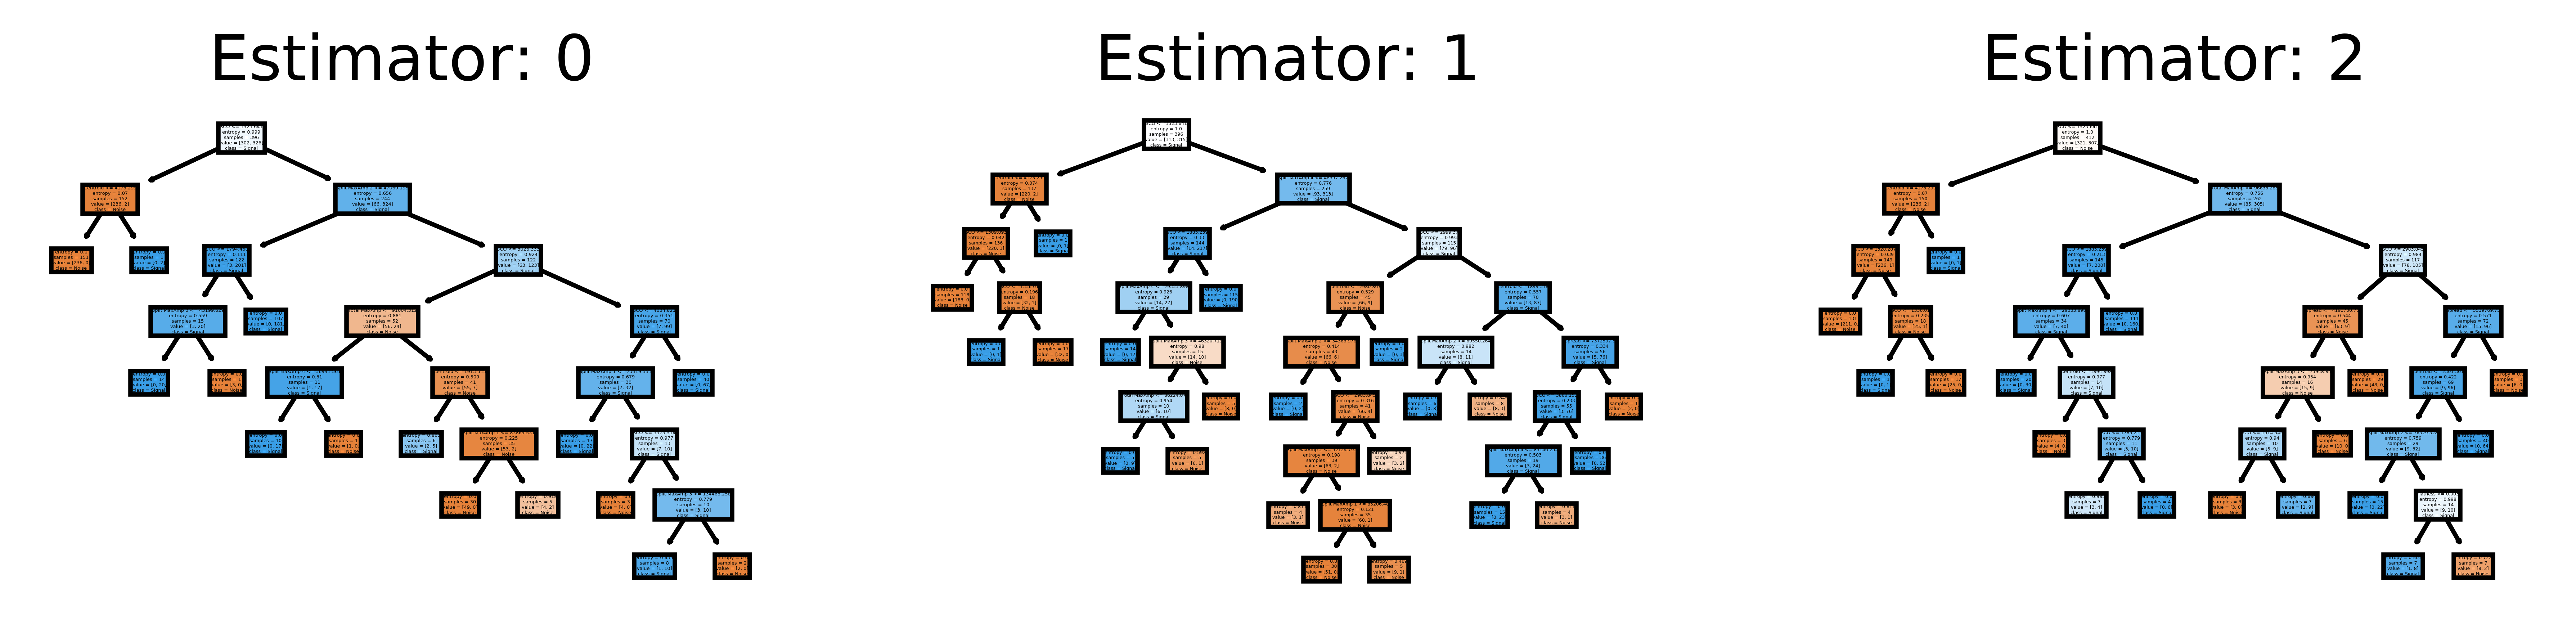

In [27]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (10,2), dpi=900)
for index in range(0, 3):
    tree.plot_tree(best_model.estimators_[index],
                   feature_names = feature_names, 
                   class_names=class_names,
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 14)
fig.savefig('rf_3trees.png')

In [28]:
############################################################################## TEST ##############################################################################

In [29]:
# Сохранение модели классификатора
classifierFilename = 'classificator.sav'
pickle.dump(best_model, open(classifierFilename, 'wb'))

In [30]:
# Path for packs
psignalPath = r"C:/Users/Vaclav/Documents/Diploma/Dirty Signals/Test/Test14/"

In [31]:
# Extracting the dataframes (data characteristics)
psignalDataFrame = sigp.extract_data(psignalPath)

C:\Users\Vaclav\Documents\Diploma\Notebooks\Classifier\signalprocessing.py:318: RuntimeWarning: divide by zero encountered in log
  return (np.exp((1 / length) * np.sum(np.log(magnitudes)))) / ((1 / length) * np.sum(magnitudes))


In [32]:
#psignalDataFrame = smfccp.pca_dataframe(psignalDataFrame, 25)
#rng = range(0, int((len(list(psignalDataFrame))-1)/2)+1)
#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]
#psignalDataFrame.columns = new_cols[:len(list(psignalDataFrame))]

In [33]:
psignalDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness
0,42997.873171,14779.439209,33166.502582,15072.479132,13263.695415,482.419260,2860.531677,4.771358e+06,0.007189
1,27979.113104,3045.376987,10608.071788,24832.547663,3366.500152,667.505219,1639.811293,3.711486e+06,0.007114
2,29504.898232,21591.040987,14007.968954,13662.505689,3492.895332,790.050931,1694.469539,4.037531e+06,0.007103
3,123330.979513,66604.648402,64468.496312,58460.458998,55369.324941,1518.164028,2967.759780,5.157186e+06,0.004263
4,64952.594449,30796.262436,34015.402079,29321.961700,34750.446254,581.451845,3808.945192,4.818796e+06,0.005925
...,...,...,...,...,...,...,...,...,...
521,22201.653852,4829.958707,16654.904206,9968.889850,8374.505111,622.109908,1554.217597,3.448562e+06,0.007707
522,61524.018934,8031.841135,57254.891928,19644.052367,5420.236412,823.281588,2340.530860,3.731637e+06,0.005453
523,57137.155257,9509.176707,34040.748960,40816.124084,15496.102426,908.545959,2180.220824,3.922567e+06,0.005582
524,63410.922217,8115.088249,49057.366298,38832.276903,6767.217994,988.747457,2242.718181,4.021604e+06,0.005411


In [34]:
# Predicting the classification
predictedData = best_model.predict(psignalDataFrame)
predictedsignalDataFrame = psignalDataFrame.assign(Flag=predictedData)

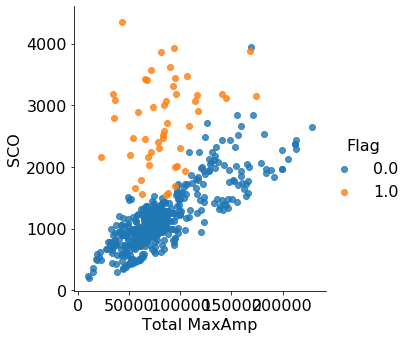

In [35]:
sn.lmplot('Total MaxAmp', 'SCO', data=predictedsignalDataFrame, hue="Flag", fit_reg=False)
#sn.lmplot('type_1', 'type_6', data=learningDataframe, hue="Flag", fit_reg=False)

In [36]:
# Loading wav files for spectrogramms
audiolist = sigp.load_list_of_wav(psignalPath)
temp = audiolist
ppredictedsignalDataFrame = predictedsignalDataFrame.loc[predictedsignalDataFrame['Flag'] == 1]
ppredictedsignalDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,Flag
5,35446.007465,1033.524119,30602.157720,16565.676649,1012.978676,2786.030545,2963.141391,2.565358e+06,0.004754,1.0
6,85672.120725,26880.006769,39599.390522,55893.780768,32717.743153,3073.636692,2940.543310,3.848542e+06,0.004573,1.0
7,79532.627736,21322.031099,47757.137296,42287.946789,25574.603146,2302.110715,3156.121989,4.017041e+06,0.004586,1.0
8,84246.547011,25358.358942,46748.574907,47036.763235,29947.407009,2998.258616,2986.971700,4.126837e+06,0.004555,1.0
9,78687.963596,51409.046951,34261.731490,30891.118609,28669.542539,2397.445414,2982.655435,4.071609e+06,0.004875,1.0


In [37]:
sigp.plot_all_spectrogramms(audiolist, predictedsignalDataFrame, 512, 0, 5, 0)

Signal amount is  49


In [38]:
audiolist[5].make_audio()

In [39]:
#sigp.copy_filtered_signal(psignalPath, 45)

In [40]:
############################################################################## AdaBoost ##############################################################################

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [42]:
# 30% экземпляров на обучение
X_train, X_test, y_train, y_test = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=0)

abc = AdaBoostClassifier(base_estimator=best_model, n_estimators=300000000, learning_rate=1)

model = abc.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('AdaBoosted RF\n',
classification_report(y_test, y_pred, target_names=['Noise', 'Signal']))

AdaBoosted RF
               precision    recall  f1-score   support

       Noise       0.99      0.97      0.98        98
      Signal       0.97      0.99      0.98        91

    accuracy                           0.98       189
   macro avg       0.98      0.98      0.98       189
weighted avg       0.98      0.98      0.98       189



In [43]:
# Отчет о классификации RF
print('RF\n',
      classification_report(test_labels, best_model.predict(test), target_names=['Noise', 'Signal']))

RF
               precision    recall  f1-score   support

       Noise       0.99      0.98      0.98        98
      Signal       0.98      0.99      0.98        91

    accuracy                           0.98       189
   macro avg       0.98      0.98      0.98       189
weighted avg       0.98      0.98      0.98       189



In [44]:
import os
import pickle
import pandas as pd
import numpy as np
import signalprocessing as sigp
import seaborn as sn
import soundmfccparams as smfccp

name = "Test18"
# Путь к сигналам
signalPath = r"C:/Users/Vaclav/Documents/Diploma/Dirty Signals/Test/"+name

# Extracting the dataframes (data characteristics)
signalDataFrame = sigp.extract_data(signalPath)

# Разметка классов
zeroes = {'Flag': np.zeros(len(signalDataFrame))}
zeroesFlag = pd.DataFrame(data=zeroes)
zeroesFlag['Flag'][17] = 1
zeroesFlag['Flag'][49] = 1
zeroesFlag['Flag'][82] = 1
zeroesFlag['Flag'][171] = 1
zeroesFlag['Flag'][193] = 1
zeroesFlag['Flag'][206] = 1
zeroesFlag['Flag'][212] = 1
zeroesFlag['Flag'][233] = 1
zeroesFlag['Flag'][234] = 1

# Adding "Flag" fields
signalDataFrame = signalDataFrame.assign(Flag=zeroesFlag['Flag'])
signalDataFrame

C:\Users\Vaclav\Documents\Diploma\Notebooks\Classifier\signalprocessing.py:318: RuntimeWarning: divide by zero encountered in log
  return (np.exp((1 / length) * np.sum(np.log(magnitudes)))) / ((1 / length) * np.sum(magnitudes))


,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,Flag
0,94203.982948,33444.911932,66378.343279,46713.494332,32067.496360,1725.924446,2236.740549,4.862294e+06,0.004463,0.0
1,155319.269450,64152.917377,74019.104843,96978.728761,68026.615270,2112.749281,2509.164903,4.329644e+06,0.003574,0.0
2,65830.221777,25727.017673,42536.341287,34516.789746,24847.463443,982.754923,2629.119726,5.439163e+06,0.005576,0.0
3,159336.293958,0.000000,89106.653956,102698.379545,79085.218794,2026.739865,2522.398870,4.173328e+06,0.003533,0.0
4,165815.904072,0.000000,99520.072977,98679.530627,83336.365392,2197.463056,2457.926455,4.134744e+06,0.003438,0.0
...,...,...,...,...,...,...,...,...,...,...
235,160959.582284,98253.976915,80428.318858,62573.002342,74842.251661,2254.959714,2419.663910,4.196780e+06,0.003478,0.0
236,154599.536678,67780.644053,83985.347051,88645.639057,66394.570127,1895.554950,2729.377884,4.678745e+06,0.003717,0.0
237,117466.738588,47860.663331,81125.516477,48687.554462,48618.778357,1699.690097,2412.969415,4.220367e+06,0.004074,0.0
238,120421.331682,65470.672087,53597.631228,51180.444154,67456.137655,1614.091067,2619.706584,4.664087e+06,0.004169,0.0


In [45]:
# Predicting the classification
predictedData = model.predict(signalDataFrame.drop(columns=['Flag']))
predictedsignalDataFrame = signalDataFrame.assign(Flag=predictedData)

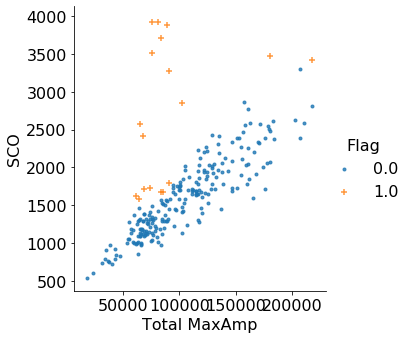

In [46]:
sn.lmplot('Total MaxAmp', 'SCO', data=predictedsignalDataFrame, hue="Flag", fit_reg=False, markers=['.','+'])

Confusion matrix, without normalization
[[214  17]
 [  8   1]]


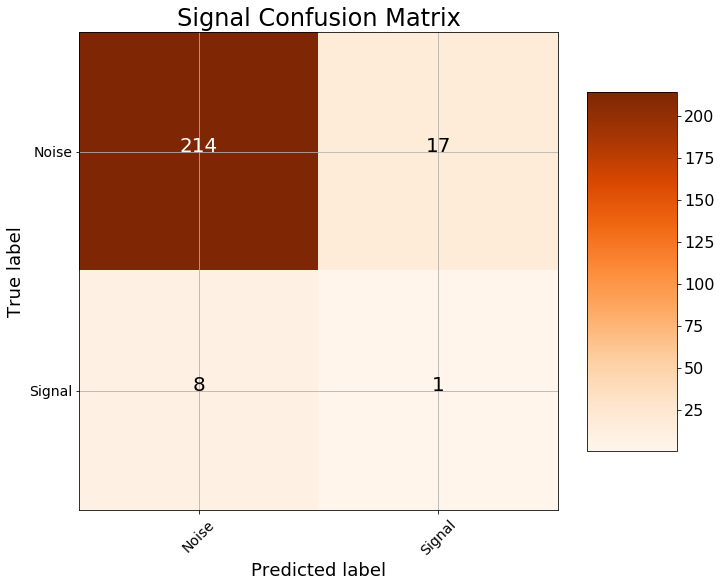

In [47]:
cm = sigp.confusion_matrix(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'])
sigp.plot_confusion_matrix(cm, classes = ['Noise', 'Signal'], title = 'Signal Confusion Matrix')

In [48]:
print('AdaBoosted RF\n',
classification_report(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'], target_names=['Noise', 'Signal']))

AdaBoosted RF
               precision    recall  f1-score   support

       Noise       0.96      0.93      0.94       231
      Signal       0.06      0.11      0.07         9

    accuracy                           0.90       240
   macro avg       0.51      0.52      0.51       240
weighted avg       0.93      0.90      0.91       240



In [49]:
############################################################################## XGBoost ##############################################################################

In [50]:
# 30% экземпляров на обучение
X_train, X_test, y_train, y_test = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=0)

In [51]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [52]:
param = {
   'max_depth': 18,
   'eta': 0.03, 
   'silent': 1, 
   'objective': 'multi:softprob',
   'num_class': 2}
num_round = 20000

In [53]:
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

[01:39:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [54]:
best_preds = np.asarray([np.argmax(line) for line in preds])
print('XGBoosted RF\n',
classification_report(y_test, best_preds, target_names=['Noise', 'Signal']))

XGBoosted RF
               precision    recall  f1-score   support

       Noise       0.96      0.96      0.96        98
      Signal       0.96      0.96      0.96        91

    accuracy                           0.96       189
   macro avg       0.96      0.96      0.96       189
weighted avg       0.96      0.96      0.96       189



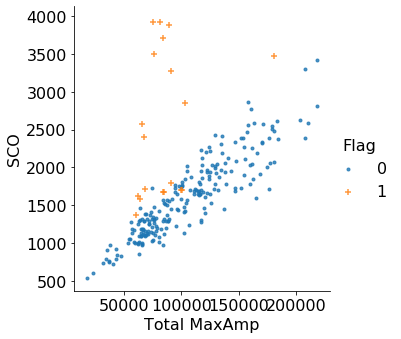

In [55]:
# APROBATION
# Predicting the classification
dtest = xgb.DMatrix(signalDataFrame.drop(columns=['Flag']), label=signalDataFrame['Flag'])
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
predictedsignalDataFrame = signalDataFrame.assign(Flag=best_preds)
sn.lmplot('Total MaxAmp', 'SCO', data=predictedsignalDataFrame, hue="Flag", fit_reg=False, markers=['.','+'])

Confusion matrix, without normalization
[[213  18]
 [  8   1]]


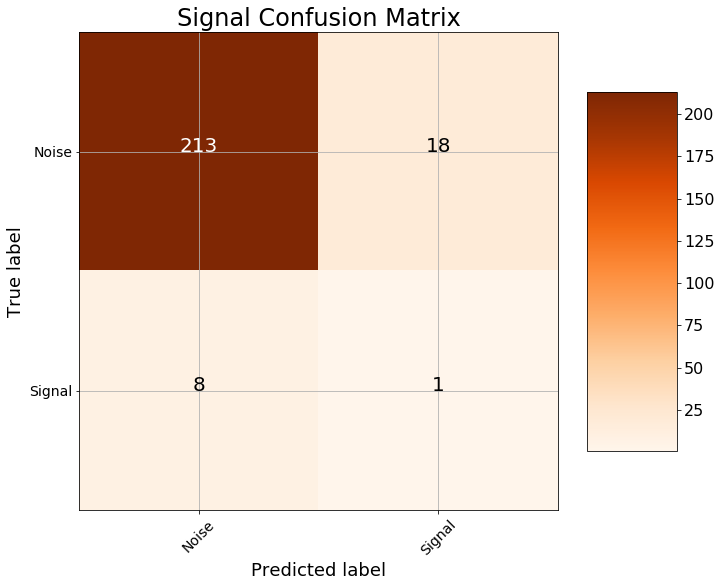

In [56]:
cm = sigp.confusion_matrix(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'])
sigp.plot_confusion_matrix(cm, classes = ['Noise', 'Signal'], title = 'Signal Confusion Matrix')

In [57]:
print('XGBoosted RF\n',
classification_report(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'], target_names=['Noise', 'Signal']))

XGBoosted RF
               precision    recall  f1-score   support

       Noise       0.96      0.92      0.94       231
      Signal       0.05      0.11      0.07         9

    accuracy                           0.89       240
   macro avg       0.51      0.52      0.51       240
weighted avg       0.93      0.89      0.91       240



In [58]:
############################################################################## MLPClassifier Perceptron ##############################################################################

In [59]:
from sklearn.neural_network import MLPClassifier

In [60]:
perceptron = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), max_iter=200, random_state=0)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}
# [0.0001, 0.05],
# 30% экземпляров на обучение
X_train, X_test, y_train, y_test = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=0)

In [61]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(perceptron, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

F:\Applications\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=1e-05,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(5, 2),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=0...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001,

In [62]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
perceptron = clf

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.551 (+/-0.031) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.560 (+/-0.029) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.551 (+/-0.031) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.560 (+/-0.029) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.551 (+/-0.031) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.549 (+/-0.061) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'ada

In [63]:
#perceptron.fit(X_train, y_train)

In [64]:
perceptron.score(X_train, y_train)

0.8314350797266514

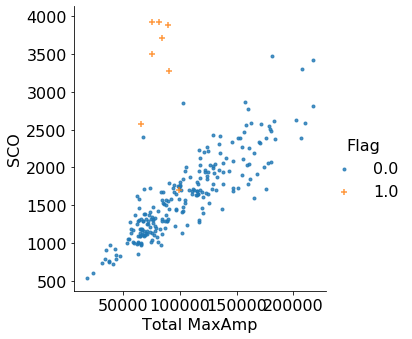

In [65]:
# APROBATION
# Predicting the classification
predictedData = perceptron.predict(signalDataFrame.drop(columns=['Flag']))
predictedsignalDataFrame = signalDataFrame.assign(Flag=predictedData)
sn.lmplot('Total MaxAmp', 'SCO', data=predictedsignalDataFrame, hue="Flag", fit_reg=False, markers=['.','+'])

Confusion matrix, without normalization
[[224   7]
 [  8   1]]


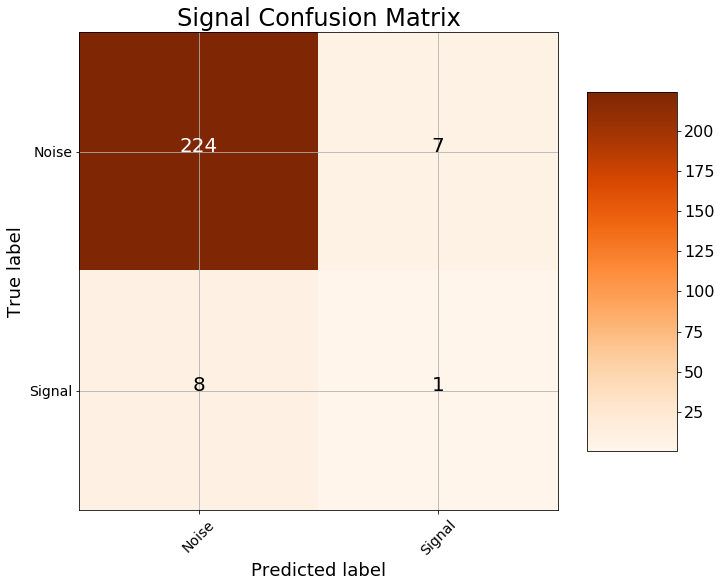

In [66]:
cm = sigp.confusion_matrix(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'])
sigp.plot_confusion_matrix(cm, classes = ['Noise', 'Signal'], title = 'Signal Confusion Matrix')

In [67]:
print('MLP\n',
classification_report(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'], target_names=['Noise', 'Signal']))

MLP
               precision    recall  f1-score   support

       Noise       0.97      0.97      0.97       231
      Signal       0.12      0.11      0.12         9

    accuracy                           0.94       240
   macro avg       0.55      0.54      0.54       240
weighted avg       0.93      0.94      0.94       240



In [68]:
############################################################################## Naive Bayes ##############################################################################

In [69]:
from sklearn.naive_bayes import GaussianNB

# 30% экземпляров на обучение
X_train, X_test, y_train, y_test = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=0)

In [70]:
model = GaussianNB()
model.fit(X_train, y_train);

In [71]:
y_pred = model.predict(X_test)

print('Naive Bayes\n',
classification_report(y_test, y_pred, target_names=['Noise', 'Signal']))

Naive Bayes
               precision    recall  f1-score   support

       Noise       0.77      0.89      0.82        98
      Signal       0.86      0.71      0.78        91

    accuracy                           0.80       189
   macro avg       0.81      0.80      0.80       189
weighted avg       0.81      0.80      0.80       189



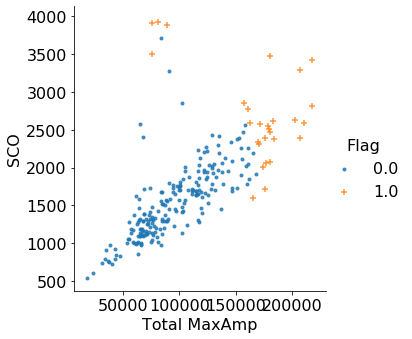

In [72]:
# APROBATION
# Predicting the classification
predictedData = model.predict(signalDataFrame.drop(columns=['Flag']))
predictedsignalDataFrame = signalDataFrame.assign(Flag=predictedData)
sn.lmplot('Total MaxAmp', 'SCO', data=predictedsignalDataFrame, hue="Flag", fit_reg=False, markers=['.','+'])

Confusion matrix, without normalization
[[205  26]
 [  7   2]]


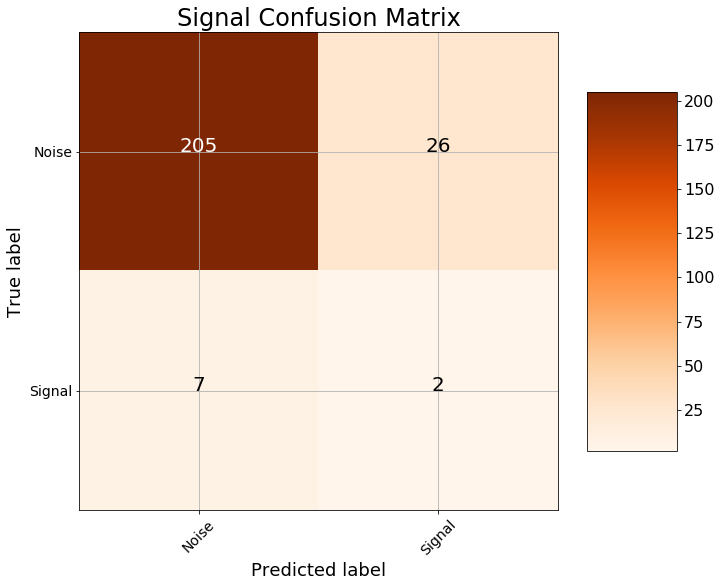

In [73]:
cm = sigp.confusion_matrix(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'])
sigp.plot_confusion_matrix(cm, classes = ['Noise', 'Signal'], title = 'Signal Confusion Matrix')

In [74]:
print('Naive Bayes Abrobation\n',
classification_report(signalDataFrame['Flag'], predictedsignalDataFrame['Flag'], target_names=['Noise', 'Signal']))

Naive Bayes Abrobation
               precision    recall  f1-score   support

       Noise       0.97      0.89      0.93       231
      Signal       0.07      0.22      0.11         9

    accuracy                           0.86       240
   macro avg       0.52      0.55      0.52       240
weighted avg       0.93      0.86      0.89       240



In [75]:
############################################################################## SVM ##############################################################################

In [77]:
# 30% экземпляров на обучение
X_train, X_test, y_train, y_test = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=0)

In [78]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'sigmoid']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

model = grid

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.2s


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.5s finished


In [79]:
y_pred = model.predict(X_test)

print('Naive Bayes\n',
classification_report(y_test, y_pred, target_names=['Noise', 'Signal']))

Naive Bayes
               precision    recall  f1-score   support

       Noise       0.00      0.00      0.00        98
      Signal       0.48      1.00      0.65        91

    accuracy                           0.48       189
   macro avg       0.24      0.50      0.33       189
weighted avg       0.23      0.48      0.31       189



F:\Applications\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
